In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
# Load the data
data = pd.read_csv("dataset/recipes_82k.csv")
data.head()

,category,cooking_method,cuisine,image,ingredients,prep_time,recipe_name,serves,tags
0,NaN,['Set the racks in the middle and upper thirds...,['American'],https://www.skinnytaste.com/wp-content/uploads...,"['1 tablespoons extra virgin olive oil', '1 cu...",20 minutes,Mediterranean Sea Bass,4 servings,"Dairy Free, Gluten Free, Keto Recipes, Kid Fri..."
1,NaN,['Place the eggs in the air fryer basket and c...,['American'],https://www.skinnytaste.com/wp-content/uploads...,"['4 large eggs', 'Salt (black pepper, everythi...",15 minutes,Air Fryer Hard Boiled Eggs,4 eggs,"Air Fryer Recipes, Dairy Free, Gluten Free, Ke..."
2,NaN,"['Air Fryer directions:', 'Preheat air fryer t...",['American'],https://www.skinnytaste.com/wp-content/uploads...,"['olive oil spray', '4 about 5 ounce each salm...",5 minutes,Air Fryer Basil-Parmesan Salmon,4 servings,"Air Fryer Recipes, Gluten Free, Keto Recipes, ..."
3,NaN,"['Preheat the oven to 400F.', 'Pour 2 tablespo...",['American'],https://www.skinnytaste.com/wp-content/uploads...,['1/2 cup freshly grated Parmesan (not pre-gra...,15 minutes,Everything Parmesan Crisps,4 servings,"Gluten Free, Keto Recipes, Kid Friendly, Low C..."
4,NaN,['Cook potatoes in a large pot of salted water...,['American'],https://www.skinnytaste.com/wp-content/uploads...,['3 1/2 pounds new potatoes (about 10 peeled a...,10 minutes,Potato and Green Bean Salad,12 servings,"Dairy Free, Gluten Free, Kid Friendly, Vegetar..."


In [12]:
data.drop(columns=['category', 'image', 'serves', 'cuisine', 'prep_time'], inplace=True)

In [13]:
data.dropna(subset=['tags'], inplace=True)
data.head()

,cooking_method,ingredients,recipe_name,tags
0,['Set the racks in the middle and upper thirds...,"['1 tablespoons extra virgin olive oil', '1 cu...",Mediterranean Sea Bass,"Dairy Free, Gluten Free, Keto Recipes, Kid Fri..."
1,['Place the eggs in the air fryer basket and c...,"['4 large eggs', 'Salt (black pepper, everythi...",Air Fryer Hard Boiled Eggs,"Air Fryer Recipes, Dairy Free, Gluten Free, Ke..."
2,"['Air Fryer directions:', 'Preheat air fryer t...","['olive oil spray', '4 about 5 ounce each salm...",Air Fryer Basil-Parmesan Salmon,"Air Fryer Recipes, Gluten Free, Keto Recipes, ..."
3,"['Preheat the oven to 400F.', 'Pour 2 tablespo...",['1/2 cup freshly grated Parmesan (not pre-gra...,Everything Parmesan Crisps,"Gluten Free, Keto Recipes, Kid Friendly, Low C..."
4,['Cook potatoes in a large pot of salted water...,['3 1/2 pounds new potatoes (about 10 peeled a...,Potato and Green Bean Salad,"Dairy Free, Gluten Free, Kid Friendly, Vegetar..."


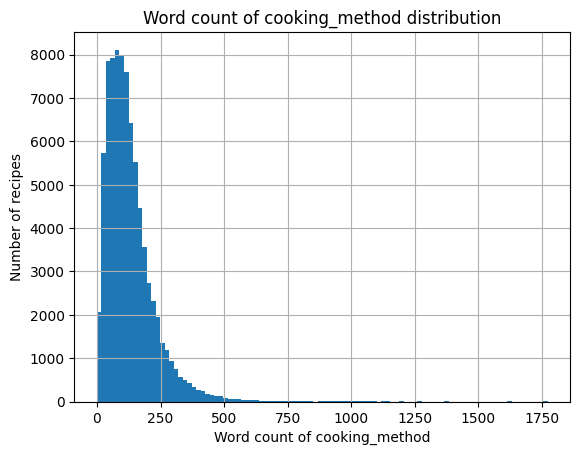

In [9]:
# number of words not letters
data['cooking_method'].str.split().apply(lambda x: len([word for word in x if word.isalpha()])).hist(bins=100)
plt.xlabel('Word count of cooking_method')
plt.ylabel('Number of recipes')
plt.title('Word count of cooking_method distribution')
plt.show()


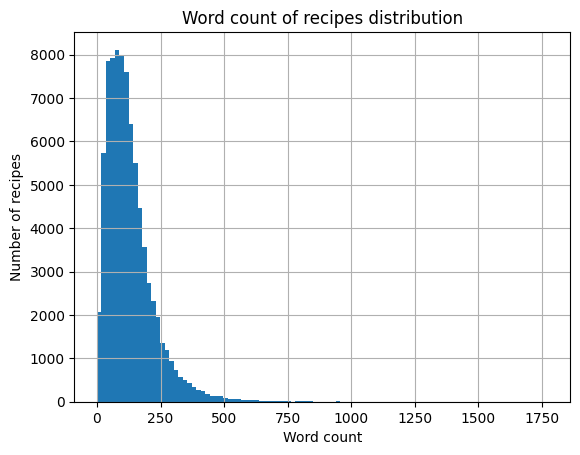

In [26]:
# count the number of words in the cooking_method column
data['cooking_method_word_count'] = data['cooking_method'].str.split().apply(lambda x: len([word for word in x if word.isalpha()]))
data['cooking_method_word_count'].describe()
#plot the distribution of the number of words in the cooking_method column
data['cooking_method_word_count'].hist(bins=100)
plt.xlabel('Word count')
plt.ylabel('Number of recipes')
plt.title('Word count of recipes distribution')
plt.show()


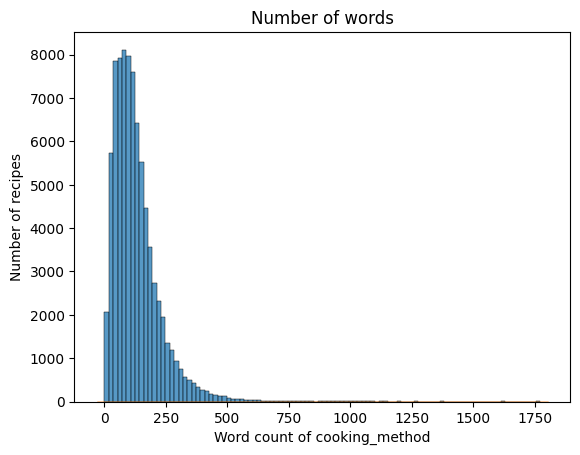

In [22]:
#make it more formal with seaborn
import seaborn as sns
sns.histplot(data['cooking_method_word_count'], bins=100)
plt.xlabel('Word count of cooking_method')
plt.ylabel('Number of recipes')
plt.title('Number of words')
#apply a smoothing kernel density estimaten and overlay it on the histogram
sns.kdeplot(data['cooking_method_word_count'], fill=True)
plt.show()


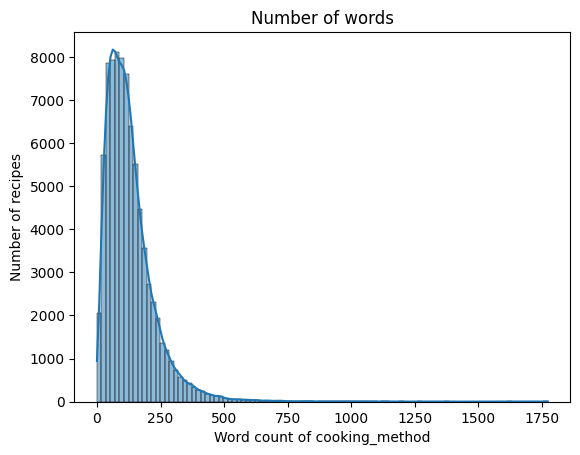

In [24]:
#plot the distribution of the number of words in the cooking_method column with a smoothing kernel density estimate overlay
sns.histplot(data['cooking_method_word_count'], bins=100, kde=True, fill=True)
plt.xlabel('Word count of cooking_method')
plt.ylabel('Number of recipes')
plt.title('Number of words')
plt.show()


/var/folders/r7/204yvtz15gq3t73qg5kdwc_00000gn/T/ipykernel_14231/2107792008.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data['cooking_method_word_count'], bins=100, kde=True, fill=True, palette='viridis')


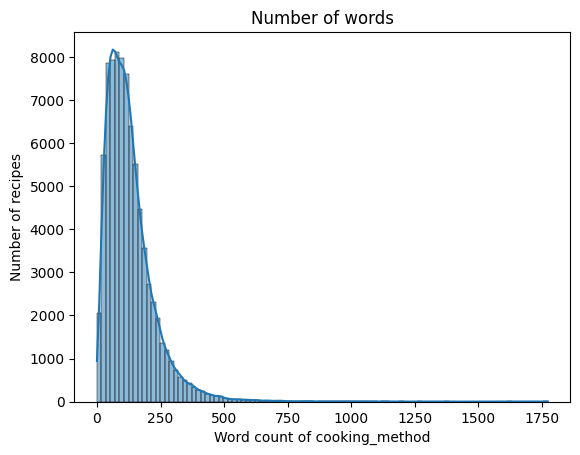

In [25]:
# make it 2 different but similar color and fill the smoothing kernel density estimate
sns.histplot(data['cooking_method_word_count'], bins=100, kde=True, fill=True, palette='viridis')
plt.xlabel('Word count of cooking_method')
plt.ylabel('Number of recipes')
plt.title('Number of words')
plt.show()

In [2]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import torch

In [3]:
PATH = '.\\dataset\\recipes_df_r.csv'

df = pd.read_csv(PATH)

In [7]:
def get_ingredients(recipe: str, ner_result: list):
    ingredients = []
    last_added = 0
    b_word = 'B-FOOD'
    i_word = 'I-FOOD'

    for i in range(len(ner_result)):

        if ner_result[i]['entity'] == b_word:
            # check if previous word was a segmentation of the same one
            if ner_result[i]['word'].startswith('#') and ner_result[i-1]['entity'] == b_word:
                # if (for any reason (it happens)) the first word is a segment, we ignore it
                if last_added == 0:
                    continue
                ingredients[last_added-1] += recipe[ner_result[i]['start'] : ner_result[i]['end']]
            else:
                # get the ingredient from the recipe given its position
                ingredients.append(recipe[ner_result[i]['start'] : ner_result[i]['end']])
                last_added += 1

        elif ner_result[i]['entity'] == i_word:
            # check if segmentation is occurring
            if ner_result[i]['word'].startswith('#'):
                # if (for any reason (it happens)) the first word is a segment, we ignore it
                if last_added == 0:
                    continue
                ingredients[last_added-1] += recipe[ner_result[i]['start'] : ner_result[i]['end']]
            elif last_added == 0:
                ingredients.append(recipe[ner_result[i]['start'] : ner_result[i]['end']])
                last_added += 1
            else:
                ingredients[last_added-1] = ingredients[last_added-1] + ' ' + recipe[ner_result[i]['start'] : ner_result[i]['end']]

    return ingredients


ingredients_list = []

tokenizer = AutoTokenizer.from_pretrained("Dizex/FoodBaseBERT")
model = AutoModelForTokenClassification.from_pretrained("Dizex/FoodBaseBERT")

if torch.cuda.is_available():
    model = model.to('cuda')
    print("Model moved to GPU.")
else:
    print("CUDA is not available. Model will run on CPU.")

pipe = pipeline("ner", model=model, tokenizer=tokenizer)

for i, recipe in tqdm(enumerate(df.ingredients), total=len(df.ingredients)):
    ingredients_list.append([])
    ner_result = pipe(recipe)
    ingredients = get_ingredients(recipe, ner_result)
    for ingredient in ingredients:
        ingredients_list[i].append(ingredient)



Model moved to GPU.


100%|██████████| 5000/5000 [12:52<00:00,  6.47it/s]


In [8]:
# write the ingredient ina file csv, where each row is a recipe and each column is an ingredient
ingredients_df = pd.DataFrame(ingredients_list)
ingredients_df.to_csv('.\\dataset\\ingredients_list_5k_2.csv', index=False)



In [4]:
PATH = '.\\dataset\\recipes_df_r.csv'

df = pd.read_csv(PATH)


In [5]:
PATH = '.\\dataset\\ingredients_list_5k_2.csv'

# read the csv in PATH adn store it ad a list of lists
ingredients_list = pd.read_csv(PATH).values.tolist()

In [6]:
# read the csv in PATH adn store it ad a list of lists ignoring the nan values
ingredients_list = pd.read_csv(PATH).values.tolist()
ingredients_list = [[ingredient for ingredient in row if type(ingredient) == str] for row in ingredients_list]



In [8]:

# for each recipe, add the corresponding list of ingredients
for i, ingredients in enumerate(ingredients_list):
    df.at[i, 'ingredients_list'] = ingredients


In [9]:

print(df.ingredients_list[105])


['sugar', 'fresh lemon juice', 'vanilla extract', 'cloves', 'ripe peaches']


In [10]:
df.head()

,cooking_method,ingredients,recipe_name,tags,Vegetarian&Desserts,Others&D,Vegetarian,Others,Dairy Free,Gluten Free,Low Carb,Low Fat,Low Sodium,ingredients_list
0,['In large skillet add the oil and heat. Add a...,"['1/4 cup olive oil', '1/2 pound fresh salmon'...",Seafood Parrillada,"Shellfish Recipes,Shrimp,Vegetable,Zucchini Re...",0,1,0,1,0,0,0,0,0,"[olive oil, fresh salmon, scallops, calamari r..."
1,['Slice meat into 1/2-thick by 2 -nch long ver...,"['1 1/2 pounds beef tenderloin fillet', 'Salt ...",Beef Stroganoff,"Easy Main Dish,Easy,Main Dish,European Recipes...",0,1,0,1,0,0,0,0,0,"[beef tenderloin fillet, Salt, pepper, butter,..."
2,['Remove the stem end from the eggplants. Cut ...,"['2 eggplants', '2 tablespoons kosher salt', '...",Pickled Grilled Eggplant,"Easy Main Dish,Easy,Main Dish,Easy Side Dish R...",1,0,1,0,0,1,0,0,0,"[eggplants, kosher salt, extra, -, virgin oliv..."
3,['Bring the Basic Bechamel Sauce to a simmer o...,"['Basic Bechamel Sauce, recipe follows', '2 ou...",Colorado River of Cheese and Macaroni,"Comfort Food Restaurants,American,Pasta Recipe...",1,0,1,0,0,0,0,0,0,"[Becha, mel Sauce, white wine, ground mustard,..."
4,['Place the beef in a large bowl and add all t...,['2.2 pounds (1 kilogram) good quality beef or...,Beef Bourguignon,"Beef Stew,Beef,Meat,Stew Recipes,French Recipe...",0,1,0,1,0,1,0,0,0,"[quality beef, Charolais beef, Burgundian wine..."


In [11]:
# drop all the rows with ingredients_list equal to []
df = df[df['ingredients_list'].map(lambda d: len(d)) > 0]


In [12]:
len(df)

4952

In [13]:
df.reset_index(drop=True, inplace=True)

In [33]:
# for each ingredient_list create the embedding of the ingredients
import sentence_transformers

model = sentence_transformers.SentenceTransformer('paraphrase-MiniLM-L6-v2')

embeddings_list = []


for i in tqdm(range(len(df))):
    embeddings_list.append(model.encode(df.ingredients_list[i]))



100%|██████████| 4952/4952 [01:14<00:00, 66.04it/s]


In [34]:
embeddings_list[0]

array([[ 0.16153346, -0.17189576, -0.08036008, ..., -0.07374836,
         0.9929299 ,  0.27412033],
       [-0.23818754, -0.13046715,  0.54928637, ...,  0.0324237 ,
         0.33550996,  0.36409244],
       [-0.33253923, -0.34338462, -1.1269889 , ..., -0.41168505,
        -0.28774807,  1.4080386 ],
       ...,
       [-0.34715977, -0.09109483, -0.34239766, ..., -1.0212771 ,
         0.48311624, -0.08793435],
       [-0.35589033, -0.5522235 , -0.02979408, ..., -0.1014094 ,
         0.54227924, -0.24927756],
       [ 0.0318573 ,  0.73872465, -0.0096142 , ..., -0.34968   ,
         0.8043511 , -0.4061306 ]], dtype=float32)

In [ ]:
# print the embeddings as vectors in a 3D space
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
pca = PCA(n_components=3)
ax = fig.add_subplot(111, projection='3d')

for i in tqdm(range(len(df.ingredients_list))):
    if len(embeddings_list[i]) < 3:
        continue
    embeddings_3d = pca.fit_transform(embeddings_list[i])
    ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2])


ax.set_xlabel('PCA dimension 1')
ax.set_ylabel('PCA dimension 2')
ax.set_zlabel('PCA dimension 3')
ax.set_title('Embeddings of the first recipe in a 3D space')
plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 214.70it/s]


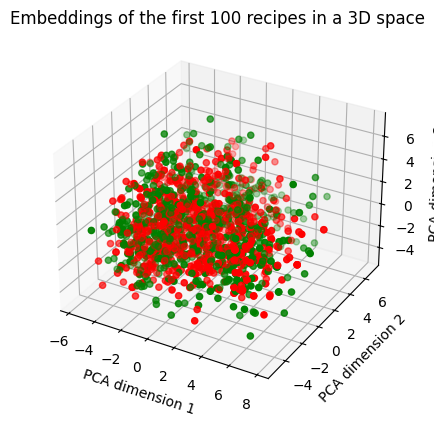

In [36]:
# do the same but with the first 100 recipes and color them based onthe Vegetarian label in the df, make the 3d image moveable
fig = plt.figure()
pca = PCA(n_components=3)
ax = fig.add_subplot(111, projection='3d')

for i in tqdm(range(100)):
    if len(embeddings_list[i]) < 3:
        continue
    embeddings_3d = pca.fit_transform(embeddings_list[i])
    if df.Vegetarian[i] == 1:
        ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], color='green')
    else:
        ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], color='red')


ax.set_xlabel('PCA dimension 1')
ax.set_ylabel('PCA dimension 2')
ax.set_zlabel('PCA dimension 3')
ax.set_title('Embeddings of the first 100 recipes in a 3D space')
plt.show()





100%|██████████| 100/100 [00:00<00:00, 130.39it/s]


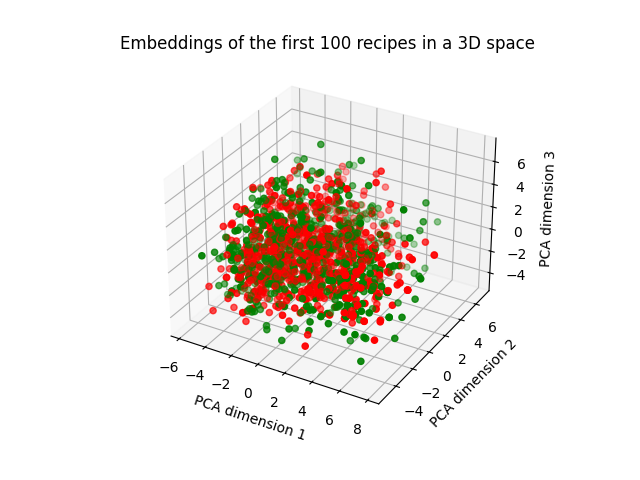

In [38]:
%matplotlib widget
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
pca = PCA(n_components=3)
ax = fig.add_subplot(111, projection='3d')

for i in tqdm(range(100)):
    if len(embeddings_list[i]) < 3:
        continue
    embeddings_3d = pca.fit_transform(embeddings_list[i])
    if df.Vegetarian[i] == 1:
        ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], color='green')
    else:
        ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], color='red')


ax.set_xlabel('PCA dimension 1')
ax.set_ylabel('PCA dimension 2')
ax.set_zlabel('PCA dimension 3')
ax.set_title('Embeddings of the first 100 recipes in a 3D space')
plt.show()




In [41]:
PATH = '.\\dataset\\ingredients_v_r.csv'

vocabulary = pd.read_csv(PATH)